In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append("../..") # add standard 's modules
# sys.path.append('/home/hbkoziel/pyfesom/codes/modules')
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

No joblib
no cmocean


In [2]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [3]:
runid	= 'Arc12'
save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/'+runid+'/' # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/DIN_budgetv2/'
plot_netcdf       = False   

In [4]:
year = 2014
doy = int(250)
dayind = int(doy*.5)
depths = mesh.zlevs
ind_max_depth = 18
depths

array([  -0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  115.,  135.,  160.,  190.,  230.,  280.,  340.,
        410.,  490.,  580.,  680.,  790.,  910., 1040., 1180., 1330.,
       1500., 1700., 1920., 2150., 2400., 2650., 2900., 3150., 3400.,
       3650., 3900., 4150., 4400., 4650., 4900., 5150., 5400., 5650.,
       5900.])

In [5]:
from derivative import derivative

bafux_2d, bafuy_2d = derivative(mesh)
f0 = 2*7.2921e-5 * np.sin(mesh.y2/180.*np.pi)

Starting derivative calculation
Derivative calculated


# FFT - spectral analysis of  advective nutrient fluxes - doy = 250 (i=125) of 2014

## 1- derive vertical eddy component

In [21]:
ncfile       = input_directory+runid+'.2014.oce.mean.nc'
f           = Dataset(ncfile, 'r')

w_mean    = f.variables['w'][dayind-22:dayind+22,:].mean(axis=0)
din_mean    = f.variables['tr01'][dayind-22:dayind+22,:].mean(axis=0)

u_mean    = f.variables['u'][dayind-22:dayind+22,:].mean(axis=0)
v_mean    = f.variables['v'][dayind-22:dayind+22,:].mean(axis=0)
din_mean    = f.variables['tr01'][dayind-22:dayind+22,:].mean(axis=0)


u = f.variables['u'][dayind,:] - u_mean
v = f.variables['v'][dayind,:] - v_mean
din = f.variables['tr01'][dayind,:] - din_mean

depth = 100
d_ind   = mesh.n32[:,10]-1

ula = np.zeros((len(mesh.x2)))* np.nan
vla = np.zeros((len(mesh.x2)))* np.nan
dinla = np.zeros((len(mesh.x2)))* np.nan 

# fill NaN arrays
ula[:] =  u[d_ind]
vla[:] =  v[d_ind]
dinla[:] =  din[d_ind]

# Starting rotation
(ux,vy)   = pf.vec_rotate_r2g(50, 15, -90, mesh.x2, mesh.y2, ula, vla, flag=1)
    
# derive derivative
uDN_elem = np.sum(ux[mesh.elem],axis=1)*np.sum(dinla[mesh.elem] * bafux_2d,axis=1)
vDN_elem = np.sum(vy[mesh.elem],axis=1)*np.sum(dinla[mesh.elem] * bafuy_2d,axis=1) #over triangle
uvDN_elem = uDN_elem + vDN_elem  

uvDN_node = np.zeros(len(mesh.x2))
uDN_node = np.zeros(len(mesh.x2))
vDN_node = np.zeros(len(mesh.x2))
ind_cnt = np.zeros(len(mesh.x2))
for ii in range(0,len(mesh.elem)):
    nod_elem=mesh.elem[ii,:]
    uDN_node[nod_elem]=uDN_node[nod_elem]+uDN_elem[ii]
    vDN_node[nod_elem]=vDN_node[nod_elem]+vDN_elem[ii]
    uvDN_node[nod_elem]=uvDN_node[nod_elem]+uvDN_elem[ii]
    ind_cnt[nod_elem]=ind_cnt[nod_elem]+1.

# masking shallower region and 1/2 level more for noise
uDN_node[mesh.topo < depth+10] = 0
vDN_node[mesh.topo < depth+10] = 0
uvDN_node[mesh.topo < depth+10] = 0

# averaging for each nodes and time convertion
uDN_node = 24 * 3600 * uDN_node/ind_cnt # convertion seconds to day
vDN_node = 24 * 3600 * vDN_node/ind_cnt # convertion seconds to day
uvDN_node = 24 * 3600 * uvDN_node/ind_cnt # convertion seconds to day

# 2- Interpolate on regular grid

In [22]:
lon = np.linspace(-180, 180, 360*60)
lat = np.linspace(-90, 90, 20*60)
lons, lats = np.meshgrid(lon,lat)

In [23]:
level_data, elem_no_nan = pf.get_data(uvDN_node,mesh,0)
nearest = pf.fesom2regular(level_data, mesh, lons, lats, how='nn')

For depth 0 model level -0.0 will be used


# 3- Derive Fourrier Transform

In [24]:
np.shape(nearest)

(1200, 21600)

In [25]:
field = nearest
np.shape(field)

(1200, 21600)

In [26]:
# Total meridional distance from 70# Stepping through longitudes
L = 2222

In [27]:
field = nearest
spw_cnt = 0.
field_spw_mean = np.zeros(len(lat)/2+1)
# Stepping through longitudes
for lo in range(0,len(lon)):
    spw_cnt = spw_cnt + 1.
    field_f = np.array(field[:,lo]) # Select section along longitudes
    N = len(field_f) # Number of measurements
    x = np.arange(N)*L/N        # N values for x-axis, from 0 to L-deltax [m]
    dx = x[1]-x[0]
    
    #======================================================================================
    # Remove the mean
    field_f2=field_f-np.nansum(field_f)/N
    
    #======================================================================================
    # Apply the window
    field_f3  = field_f2*np.hanning(N)
    field_f3 = np.nan_to_num(field_f3)
    
    #======================================================================================
    # Creating fft with window
    field_ff3    = np.fft.fft(field_f3)
    fft_fre = np.fft.fftfreq(n=(N),d=dx)
    
    #======================================================================================
    # Windowed spectrum
    c1=np.sum(np.hanning(N)**2)/N
    field_c2=np.nansum(field_f3*field_f3)/np.nansum(field_f2*field_f2)
    
    #======================================================================================
    # Windowed spectrum
    field_sp_aux=field_ff3*np.conj(field_ff3)
    
    #======================================================================================
    # Reflection to have sp(|k|), we will use k for |k| in comments.
    field_spw=field_sp_aux[0:N/2+1]                          # Only first half of values
    
    i_end = N-1
    for i in range(1,int(N/2)+1):
        field_spw[i] = field_spw[i] + field_sp_aux[i_end]
        i_end = i_end - 1
        
    field_spw=field_spw/(N*N)
    field_spw=field_spw/c1
                         
    field_spw_mean = field_spw_mean + field_spw

field_spw_mean = field_spw_mean/spw_cnt

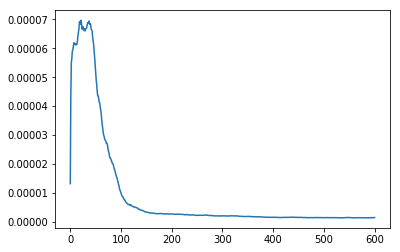

In [28]:
plt.plot(np.real(field_spw_mean))

In [29]:
#xfre = abs(fft_fre[0:N/2.+1])
xfre = abs(fft_fre[0:601])

In [30]:
logfield = np.log10(np.real(field_spw_mean[1:-1]))

In [31]:
logfre = np.log10(xfre[1:-1])

In [42]:
starti = 13#3
endi    = 120#25 
m_field,c_field = np.polyfit(logfre[starti:endi], logfield[starti:endi], 1)

print starti, endi, m_field
field_ys = 10.**c_field * xfre[1:-1]**m_field

13 120 -1.3226069444326598


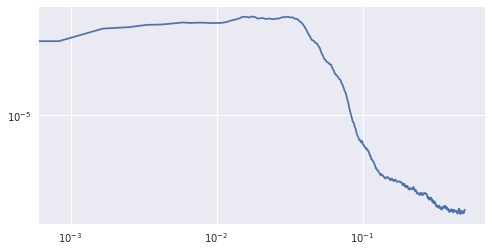

In [43]:
plt.figure(4,figsize=(8,4))
plt.style.use('seaborn')

plt.loglog(abs(fft_fre[0:601]),field_spw_mean,label='vertical eddy DIN flux')

(1e-07, 0.001)

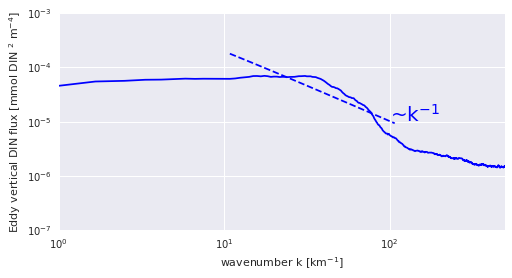

In [59]:
plt.figure(4,figsize=(8,4))
plt.style.use('seaborn')


# np.load('FFT_EDYH.npz')

# plt.loglog(abs(fft_fre[0:601])*1000,field_spw_mean,'k')
# #plt.loglog(xfre[4:33],sst_ys[4:33],'r')
# plt.loglog(xfre[starti:endi+10]*1000,field_ys[starti:endi+10],'--k')
# plt.text(100,10**(-5),r'~k$^{-1.5}$', fontsize=20)


np.load('FFT_EDYV.npz')

plt.figure(4,figsize=(8,4))
plt.style.use('seaborn')

plt.loglog(abs(fft_fre[0:601])*1000,field_spw_mean,'b')
#plt.loglog(xfre[4:33],sst_ys[4:33],'r')
plt.loglog(xfre[starti:endi+10]*1000,field_ys[starti:endi+10],'--b')
plt.text(100,10**(-5),r'~k$^{-1}$', fontsize=20, color='b')
plt.ylabel(r'Eddy vertical DIN flux [mmol DIN $^{2}$ m$^{-4}$]')
plt.xlabel(r'wavenumber k [km$^{-1}$]')
plt.xlim(1,500)
plt.ylim(10**-7,10**-3)

(1e-07, 0.001)

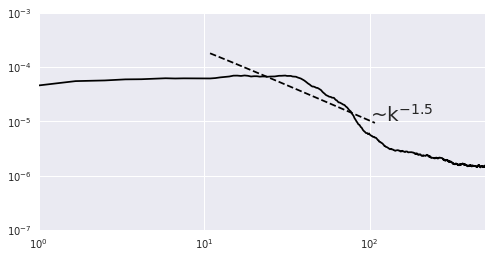

In [57]:
plt.figure(4,figsize=(8,4))
plt.style.use('seaborn')


np.load('FFT_EDYH.npz')

plt.loglog(abs(fft_fre[0:601])*1000,field_spw_mean,'k')
#plt.loglog(xfre[4:33],sst_ys[4:33],'r')
plt.loglog(xfre[starti:endi+10]*1000,field_ys[starti:endi+10],'--k')
plt.text(100,10**(-5),r'~k$^{-1.5}$', fontsize=20)
plt.xlim(1,500)
plt.ylim(10**-7,10**-3)

In [64]:
np.savez('FFT_EDYH',xfre=xfre,field_ys=field_ys,fft_fre=fft_fre,field_spw_mean=field_spw_mean,\
         starti=starti,endi=endi,m_field=m_field,c_field=c_field,logfield=logfield,logfre=logfre)